# Exerciese

## Create the training data

In [7]:
import numpy as np
from keras.datasets import mnist

# Load the data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the data
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Flatten the data
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

## Setting up the hyperparameters

In [8]:
epochs = 50
batch_size = 256
n_in_out = 784
n_hidden = 256
n_z = 2

## Create the model

In [9]:
from keras.models import Model
from keras import metrics
from keras.layers import Input, Dense, Lambda
from keras import backend as K

# Function for sampling latent variables
def sampling(args):
    mu, log_var = args
    epsilon = K.random_normal(shape=K.shape(log_var), mean=0., stddev=1.)
    return mu + K.exp(log_var / 2) * epsilon

# Create the VAE network
x = Input(shape=(n_in_out))
h = Dense(n_hidden, activation='relu')(x)

mu = Dense(n_z)(h)
log_var = Dense(n_z)(h)
z = Lambda(sampling, output_shape=(n_z,))([mu, log_var])

decoder_h = Dense(n_hidden, activation='relu')
h_decoded = decoder_h(z)
decoder_mean = Dense(n_in_out, activation='sigmoid')
y = decoder_mean(h_decoded)

# Create the VAE model
vae = Model(x, y)

# loss function
rec_loss = n_in_out * metrics.binary_crossentropy(x, y)
kl_loss = - 0.5 * K.sum(1 + log_var - K.square(mu) - K.exp(log_var), axis=-1)
vae_loss = K.mean(rec_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 784)]        0           []                               
                                                                                                  
 dense_5 (Dense)                (None, 256)          200960      ['input_3[0][0]']                
                                                                                                  
 dense_6 (Dense)                (None, 2)            514         ['dense_5[0][0]']                
                                                                                                  
 dense_7 (Dense)                (None, 2)            514         ['dense_5[0][0]']                
                                                                                            

## Train the model

In [10]:
history = vae.fit(x_train,
                  epochs=epochs,
                  shuffle=True,
                  batch_size=batch_size,
                  validation_data=(x_test, None))

Epoch 1/50
235/235 [==============================] - 19s 53ms/step - loss: 224.4288 - val_loss: 185.0421
Epoch 2/50
235/235 [==============================] - 6s 27ms/step - loss: 179.4793 - val_loss: 173.7430
Epoch 3/50
235/235 [==============================] - 8s 34ms/step - loss: 171.1861 - val_loss: 169.0161
Epoch 4/50
235/235 [==============================] - 10s 41ms/step - loss: 167.9568 - val_loss: 166.9848
Epoch 5/50
235/235 [==============================] - 9s 39ms/step - loss: 166.2337 - val_loss: 165.5419
Epoch 6/50
235/235 [==============================] - 9s 40ms/step - loss: 164.9029 - val_loss: 164.5474
Epoch 7/50
235/235 [==============================] - 10s 41ms/step - loss: 163.8985 - val_loss: 163.5302
Epoch 8/50
235/235 [==============================] - 10s 41ms/step - loss: 162.8790 - val_loss: 162.8264
Epoch 9/50
235/235 [==============================] - 10s 42ms/step - loss: 162.0999 - val_loss: 161.9759
Epoch 10/50
235/235 [=============================

## Visualize the latent space

235/235 [==============================] - 3s 9ms/step


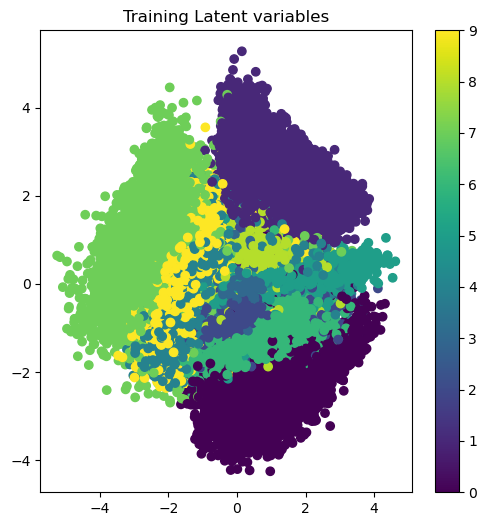

40/40 [==============================] - 1s 14ms/step


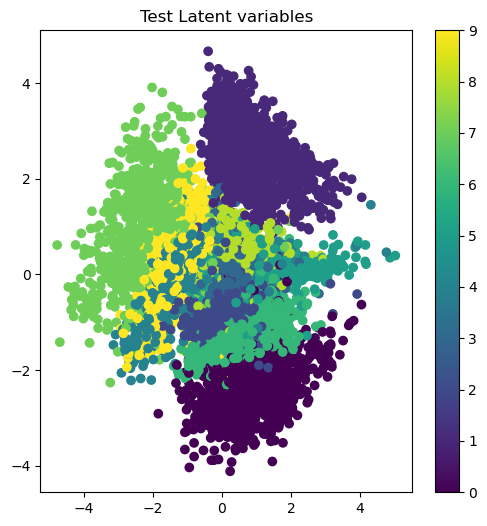

In [11]:
# Model for latent variables
encoder = Model(x, z)

# plot latent variables
import matplotlib.pyplot as plt

z_train = encoder.predict(x_train, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(z_train[:, 0], z_train[:, 1], c=y_train)
plt.title("Training Latent variables")
plt.colorbar()
plt.show()

# Model for decoded images
z_test = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(z_test[:, 0], z_test[:, 1], c=y_test)
plt.title("Test Latent variables")
plt.colorbar()
plt.show()

## Generate new images

1/1 [==============================] - 1s 948ms/step


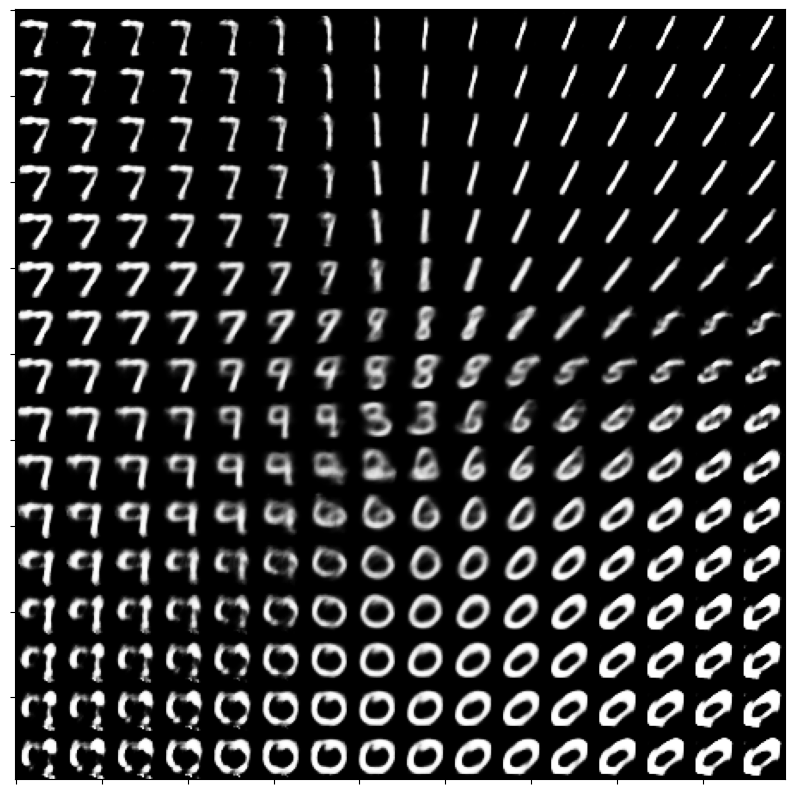

In [12]:
# Generator for new images
input_decoder = Input(shape=(n_z,))
decoder_h = decoder_h(input_decoder)
y = decoder_mean(decoder_h)
generator = Model(input_decoder, y)

# Setting the plot parameters
n = 16
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Sampling the latent variables
grid_x = np.linspace(5, -5, n)
grid_y = np.linspace(-5, 5, n)

# Generating the images
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

# Plotting the images
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
plt.show()
